In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import preprocessing_code, cryoProcessing

import re
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import graphviz
import os

from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 30,30

#os.environ["PATH"] += os.pathsep + 'C:/Users/Marc/jed/Anaconda3/envs/keras/Library/bin/graphviz/'


In [180]:
trainPath = 'train.csv'
testPath = 'test.csv'


dataDf = pd.read_csv(trainPath)
testDf = pd.read_csv(testPath)

combinedDf = pd.concat([dataDf, testDf])

In [181]:
dataDf

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Data Cleaning, Replacing NaN values, feature extraction

Check if there are columns with NaN values

In [182]:
print(dataDf.columns[dataDf.isna().any()].tolist())

['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


## Surnames extraction for families
Name - The first and last names of the passenger.

In [183]:
surnameList = []
for i in range(len(dataDf['Name'])):
    fullName = dataDf['Name'].iloc[i]
    if fullName != fullName:
        surnameList.append('unknown')
    else:
        for j in range(len(fullName)):
            if fullName[j] == " ":
                surnameList.append(fullName[j+1:])
dataDf['surname'] = surnameList

dataDf = dataDf.drop('Name', axis=1)

## PassangerID extraction for groups
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [184]:
groupList = []
for i in range(len(dataDf['PassengerId'])):
    fullId = dataDf['PassengerId'].iloc[i]
    if fullId != fullId:
        groupList.append('PassengerId')
    else:
        for j in range(len(fullId)):
            if fullId[j] == "_":
                groupList.append(fullId[:j])
dataDf['groups'] = groupList

dataDf = dataDf.drop('PassengerId', axis=1)

## Cabin dismantling 
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [185]:
numList = []
deckList = []
sideList = []

for i in range(len(dataDf['Cabin'])):
    fullCabinId = dataDf['Cabin'].iloc[i]
    if fullCabinId != fullCabinId:
        numList.append('unknown')
        deckList.append('unknown')
        sideList.append('unknown')
    else:
        num = re.findall('\d+', fullCabinId)
        numList.append(num[0])
        
        deck = fullCabinId[0]
        deckList.append(deck)
        
        side = fullCabinId[-1]
        sideList.append(side)

dataDf['num'] = numList
dataDf['deck'] = deckList
dataDf['side'] = sideList

dataDf = dataDf.drop('Cabin', axis=1)

## Replace NaN float values

Age - The age of the passenger.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

In [186]:
floatValueNames = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [187]:
for i in floatValueNames:
    meanValue = dataDf[i].mean()
    dataDf[i] = dataDf[i].fillna(meanValue)
print(dataDf.columns[dataDf.isna().any()].tolist())

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']


# Create Another Feature

In [188]:
sum_column = dataDf["RoomService"] + dataDf["FoodCourt"] + dataDf["ShoppingMall"] + dataDf["Spa"] + dataDf["VRDeck"]
dataDf["totalBill"] = sum_column

In [189]:
dataDf

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,groups,num,deck,side,totalBill
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,0,B,P,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,0,F,S,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,0,A,S,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,0,A,S,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,S,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,Noxnuther,9276,98,A,P,8536.0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,Mondalley,9278,1499,G,S,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,Connon,9279,1500,G,S,1873.0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,Hontichre,9280,608,E,S,4637.0


##  Predicting missing Values for most "important" feature of cryoSleep 

In [234]:
tmpDf = cryoProcessing(combinedDf)
#tmpDf = tmpDf.drop(['Transported'], axis = 1)

tmpDf['VIP'] = tmpDf['VIP'].astype(str)

tmp = tmpDf[['HomePlanet', 'Destination', 'surname', 'num','deck', 'side', 'VIP', 'groups', 'Transported']]

tmpDf[['HomePlanet', 'Destination', 'surname', 'deck', 'num', 'side', 'VIP', 'groups', 'Transported']] = tmp.apply(LabelEncoder().fit_transform)

In [235]:
cryoTest = tmpDf[tmpDf.isna().any(axis=1)]
cryoTest = cryoTest.drop(['CryoSleep'], axis = 1)

cryoTrain = tmpDf[~tmpDf.isna().any(axis=1)]

In [237]:
cryoTest

,HomePlanet,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,groups,num,deck,side,totalBill
92,0,2,2.0,0,0.0,0.0,0.000000,0.0,0.000000,1,510,98,6,224,0,0.000000
98,0,2,27.0,0,0.0,0.0,570.000000,2.0,131.000000,0,444,104,5,1018,0,703.000000
104,1,2,40.0,0,0.0,331.0,0.000000,0.0,1687.000000,0,230,109,1,1339,0,2018.000000
111,2,2,26.0,0,0.0,0.0,0.000000,0.0,306.789482,1,1623,114,5,1051,0,306.789482
152,0,2,58.0,0,0.0,985.0,0.000000,5.0,0.000000,1,979,172,4,113,1,990.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2,0,20.0,0,0.0,0.0,0.000000,0.0,0.000000,2,920,8704,5,880,0,0.000000
4108,1,2,27.0,0,0.0,2182.0,7.000000,2582.0,19.000000,2,1586,8924,2,1112,0,4790.000000
4209,1,2,41.0,0,0.0,1998.0,0.000000,1023.0,867.000000,2,2230,9137,8,1894,2,3888.000000
4230,0,2,14.0,0,0.0,0.0,174.906033,1377.0,29.000000,2,885,9181,5,864,1,1580.906033


In [238]:
cryoTrain
cryoTrain['CryoSleep'] = cryoTrain['CryoSleep'].astype(bool)

C:\Users\Marc\AppData\Local\Temp/ipykernel_19828/2819342246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cryoTrain['CryoSleep'] = cryoTrain['CryoSleep'].astype(bool)


In [239]:
ctrain, ctest = train_test_split(cryoTrain, test_size=0.2)

trainData = ctrain.loc[:, ctrain.columns != 'CryoSleep']
trainLabel = ctrain.loc[:, ctrain.columns == 'CryoSleep']

testData = ctest.loc[:, ctest.columns != 'CryoSleep']
testLabel = ctest.loc[:, ctest.columns == 'CryoSleep']

cdtrain = xgb.DMatrix(trainData, label=trainLabel)
cdtest = xgb.DMatrix(testData, label=testLabel)

C:\Users\Marc\anaconda3\envs\kaggle\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [240]:
bestParams ={'colsample_bytree': 0.9500000000000001,
 'eta': 0.15000000000000002,
 'gamma': 0.8,
 'max_depth': 3,
 'min_child_weight': 6.0,
 'n_estimators': 118.0,
 'subsample': 1.0}
bestParams['eval_metric'] = 'auc'

num_round = 238

evallist = [(cdtest, 'eval'), (cdtrain, 'train')]

In [241]:
cryo = xgb.train(bestParams, cdtrain, num_round ,evallist)

[12:07:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-auc:0.98200	train-auc:0.98204
[1]	eval-auc:0.98232	train-auc:0.98227
[2]	eval-auc:0.98287	train-auc:0.98333
[3]	eval-auc:0.98315	train-auc:0.98366
[4]	eval-auc:0.98296	train-auc:0.98374
[5]	eval-auc:0.98573	train-auc:0.98603
[6]	eval-auc:0.98643	train-auc:0.98649
[7]	eval-auc:0.98701	train-auc:0.98722
[8]	eval-auc:0.98723	train-auc:0.98735
[9]	eval-auc:0.98721	train-auc:0.98734
[10]	eval-auc:0.98843	train-auc:0.98897
[11]	eval-auc:0.98842	train-auc:0.98910
[12]	eval-auc:0.98907	train-auc:0.99000
[13]	eval-auc:0.98912	train-auc:0.99013
[14]	eval-auc:0.98933	train-auc:0.99042
[15]	eval-auc:0.98944	train-auc:0.99047
[16]	ev

[194]	eval-auc:0.99039	train-auc:0.99265
[195]	eval-auc:0.99039	train-auc:0.99265
[196]	eval-auc:0.99039	train-auc:0.99265
[197]	eval-auc:0.99039	train-auc:0.99265
[198]	eval-auc:0.99039	train-auc:0.99265
[199]	eval-auc:0.99039	train-auc:0.99265
[200]	eval-auc:0.99039	train-auc:0.99265
[201]	eval-auc:0.99039	train-auc:0.99265
[202]	eval-auc:0.99039	train-auc:0.99265
[203]	eval-auc:0.99039	train-auc:0.99265
[204]	eval-auc:0.99039	train-auc:0.99265
[205]	eval-auc:0.99039	train-auc:0.99265
[206]	eval-auc:0.99039	train-auc:0.99265
[207]	eval-auc:0.99039	train-auc:0.99265
[208]	eval-auc:0.99039	train-auc:0.99265
[209]	eval-auc:0.99039	train-auc:0.99265
[210]	eval-auc:0.99039	train-auc:0.99265
[211]	eval-auc:0.99039	train-auc:0.99265
[212]	eval-auc:0.99039	train-auc:0.99265
[213]	eval-auc:0.99039	train-auc:0.99265
[214]	eval-auc:0.99039	train-auc:0.99265
[215]	eval-auc:0.99039	train-auc:0.99265
[216]	eval-auc:0.99039	train-auc:0.99265
[217]	eval-auc:0.99039	train-auc:0.99265
[218]	eval-auc:0

In [242]:
cdTest = xgb.DMatrix(cryoTest)
ycryo = cryo.predict(cdTest, iteration_range=(0, bst.best_iteration))
ycryo = ycryo.tolist()

In [243]:
thresh = 0.5
prediction_cryo = []
for i in ycryo:
    if i > thresh:
        prediction_cryo.append(1)
    else:
        prediction_cryo.append(0)

In [244]:
cryoTest['CryoSleep'] = prediction_cryo

In [245]:
cryoTest

,HomePlanet,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,groups,num,deck,side,totalBill,CryoSleep
92,0,2,2.0,0,0.0,0.0,0.000000,0.0,0.000000,1,510,98,6,224,0,0.000000,1
98,0,2,27.0,0,0.0,0.0,570.000000,2.0,131.000000,0,444,104,5,1018,0,703.000000,0
104,1,2,40.0,0,0.0,331.0,0.000000,0.0,1687.000000,0,230,109,1,1339,0,2018.000000,0
111,2,2,26.0,0,0.0,0.0,0.000000,0.0,306.789482,1,1623,114,5,1051,0,306.789482,1
152,0,2,58.0,0,0.0,985.0,0.000000,5.0,0.000000,1,979,172,4,113,1,990.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2,0,20.0,0,0.0,0.0,0.000000,0.0,0.000000,2,920,8704,5,880,0,0.000000,1
4108,1,2,27.0,0,0.0,2182.0,7.000000,2582.0,19.000000,2,1586,8924,2,1112,0,4790.000000,0
4209,1,2,41.0,0,0.0,1998.0,0.000000,1023.0,867.000000,2,2230,9137,8,1894,2,3888.000000,0
4230,0,2,14.0,0,0.0,0.0,174.906033,1377.0,29.000000,2,885,9181,5,864,1,1580.906033,0


## Replacing last NaN Values

In [246]:
dataDf = dataDf.fillna('unknown')
print(dataDf.columns[dataDf.isna().any()].tolist())

[]


In [247]:
dataDf.isna().any()

HomePlanet      False
CryoSleep       False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Transported     False
surname         False
groups          False
num             False
deck            False
side            False
totalBill       False
dtype: bool

# Label Encoding 

In [248]:
dataDf['VIP'] = dataDf['VIP'].astype(str)
dataDf['CryoSleep'] = dataDf['CryoSleep'].astype(str)
dataDf['Transported'] = dataDf['Transported'].astype(str)

In [249]:
tmpDataDf = dataDf[['HomePlanet', 'Destination', 'surname', 'num', 'deck', 'side', 'groups', 'VIP', 'CryoSleep', 'Transported']]

dataDf[['HomePlanet', 'Destination', 'surname', 'num', 'deck', 'side', 'groups', 'VIP', 'CryoSleep', 'Transported']] = tmpDataDf.apply(LabelEncoder().fit_transform)

#dataDf = dataDf.apply(LabelEncoder().fit_transform)

In [250]:
dataDf.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,groups,num,deck,side,totalBill
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.000000,0,1423,0,0,1,0,0.000000
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.000000,1,2097,1,0,5,1,736.000000
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.000000,0,1979,2,0,0,1,10383.000000
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.000000,0,1979,2,0,0,1,5176.000000
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.000000,1,1768,3,1,5,1,1091.000000
5,0,0,1,44.0,0,0.0,483.0,0.0,291.0,0.000000,1,973,4,0,5,0,774.000000
6,0,0,2,26.0,0,42.0,1539.0,3.0,0.0,0.000000,1,1075,5,923,5,1,1584.000000
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,304.854791,1,1075,5,0,6,1,304.854791
8,0,0,2,35.0,0,0.0,785.0,17.0,216.0,0.000000,1,168,6,1034,5,1,1018.000000
9,1,1,0,14.0,0,0.0,0.0,0.0,0.0,0.000000,1,717,7,1,1,0,0.000000


In [251]:
dataDf.loc[cryoTest.index, :] = cryoTest[:]

In [252]:
dataDf[dataDf.isna().any(axis=1)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,groups,num,deck,side,totalBill


# Data Analysis

## Correlation Matrix

<AxesSubplot:>

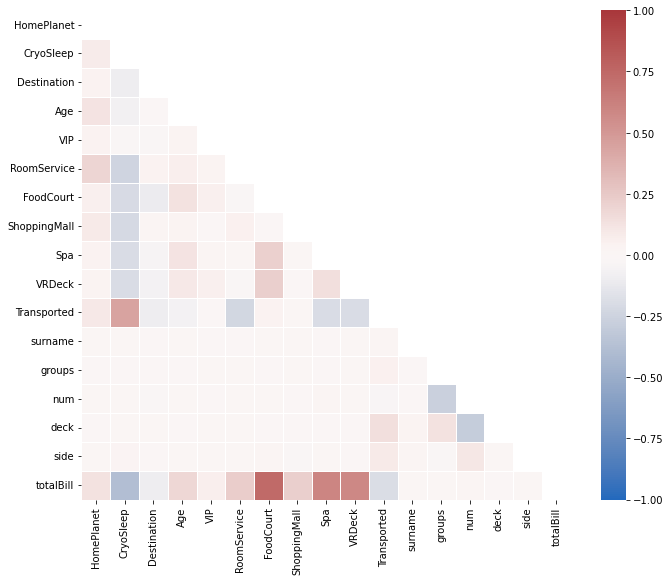

In [253]:
corr = dataDf.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0, cmap = 'vlag',
            square=True, linewidths=.5)

# Creating XGBoost Model for training

## Train Test Split

In [254]:
train, test = train_test_split(dataDf, test_size=0.2)

Data - Label Split

In [255]:
trainData = train.loc[:, train.columns != 'Transported']
trainLabel = train.loc[:, train.columns == 'Transported']

testData = test.loc[:, test.columns != 'Transported']
testLabel = test.loc[:, test.columns == 'Transported']

In [256]:
trainLabel.value_counts()

Transported
1              3461
0              3420
2                73
dtype: int64

In [257]:
dataDf.isna().any()

HomePlanet      False
CryoSleep       False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Transported     False
surname         False
groups          False
num             False
deck            False
side            False
totalBill       False
dtype: bool

Arrays

In [258]:
xtrain = trainData.to_numpy()
ytrain = trainLabel.to_numpy()

xtest = testData.to_numpy()
ytest = testLabel.to_numpy()

Converting to XGBoost Format

In [259]:
dtrain = xgb.DMatrix(trainData, label=trainLabel)
dtest = xgb.DMatrix(testData, label=testLabel)

C:\Users\Marc\anaconda3\envs\kaggle\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


# Hyperparameter Tuning - Bayesian Optimization

In [260]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
SEED = 314159265

Initialize domain space for range of values

In [261]:
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(trainData, label=trainLabel)
    dtest = xgb.DMatrix(testData, label=testLabel)
    watchlist = [(dtest, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dtest,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(ytest, predictions)
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

In [262]:
def optimize(trials,
             random_state=SEED):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, 
                max_evals=300
               )
    return best

In [ ]:
trials = Trials()
bestParams = optimize(trials)

In [ ]:
bestParams

## Model Training

In [263]:
bestParams ={'colsample_bytree': 0.9500000000000001,
 'eta': 0.15000000000000002,
 'gamma': 0.8,
 'max_depth': 3,
 'min_child_weight': 6.0,
 'n_estimators': 118.0,
 'subsample': 1.0}
bestParams['eval_metric'] = 'auc'

In [264]:
param = {'max_depth': 3, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 238

evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [266]:
bst = xgb.train(bestParams, dtrain, num_round ,evallist)

[12:08:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-auc:0.84917	train-auc:0.82199
[1]	eval-auc:0.85583	train-auc:0.83638
[2]	eval-auc:0.86260	train-auc:0.84519
[3]	eval-auc:0.86766	train-auc:0.85095
[4]	eval-auc:0.87279	train-auc:0.85921
[5]	eval-auc:0.88250	train-auc:0.86711
[6]	eval-auc:0.88517	train-auc:0.87086
[7]	eval-auc:0.88482	train-auc:0.87318
[8]	eval-auc:0.88584	train-auc:0.87410
[9]	eval-auc:0.88781	train-auc:0.87541
[10]	eval-auc:0.88944	train-auc:0.87897
[11]	eval-auc:0.89057	train-auc:0.88197
[12]	eval-auc:0.89298	train-auc:0.88339
[13]	eval-auc:0.89685	train-auc:0.88840
[14]	eval-auc:0.90044	train-auc:0.89148
[15]	eval-auc:0.90230	train-auc:0.89493
[16]	ev

[194]	eval-auc:0.92185	train-auc:0.92197
[195]	eval-auc:0.92185	train-auc:0.92197
[196]	eval-auc:0.92185	train-auc:0.92197
[197]	eval-auc:0.92185	train-auc:0.92197
[198]	eval-auc:0.92185	train-auc:0.92197
[199]	eval-auc:0.92185	train-auc:0.92197
[200]	eval-auc:0.92185	train-auc:0.92197
[201]	eval-auc:0.92185	train-auc:0.92197
[202]	eval-auc:0.92185	train-auc:0.92197
[203]	eval-auc:0.92185	train-auc:0.92197
[204]	eval-auc:0.92185	train-auc:0.92197
[205]	eval-auc:0.92185	train-auc:0.92197
[206]	eval-auc:0.92185	train-auc:0.92197
[207]	eval-auc:0.92185	train-auc:0.92197
[208]	eval-auc:0.92185	train-auc:0.92197
[209]	eval-auc:0.92185	train-auc:0.92197
[210]	eval-auc:0.92185	train-auc:0.92197
[211]	eval-auc:0.92185	train-auc:0.92197
[212]	eval-auc:0.92185	train-auc:0.92197
[213]	eval-auc:0.92185	train-auc:0.92197
[214]	eval-auc:0.92185	train-auc:0.92197
[215]	eval-auc:0.92185	train-auc:0.92197
[216]	eval-auc:0.92185	train-auc:0.92197
[217]	eval-auc:0.92185	train-auc:0.92197
[218]	eval-auc:0

In [267]:
submissionData = preprocessing_code(testDf)
dsubmData = xgb.DMatrix(submissionData)
ypred = bst.predict(dsubmData, iteration_range=(0, bst.best_iteration))
ypred = ypred.tolist()

C:\Users\Marc\anaconda3\envs\kaggle\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [268]:
thresh = 0.5
prediction = []
for i in ypred:
    if i > thresh:
        prediction.append(1)
    else:
        prediction.append(0)

In [269]:
prediction = [bool(x) for x in prediction]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

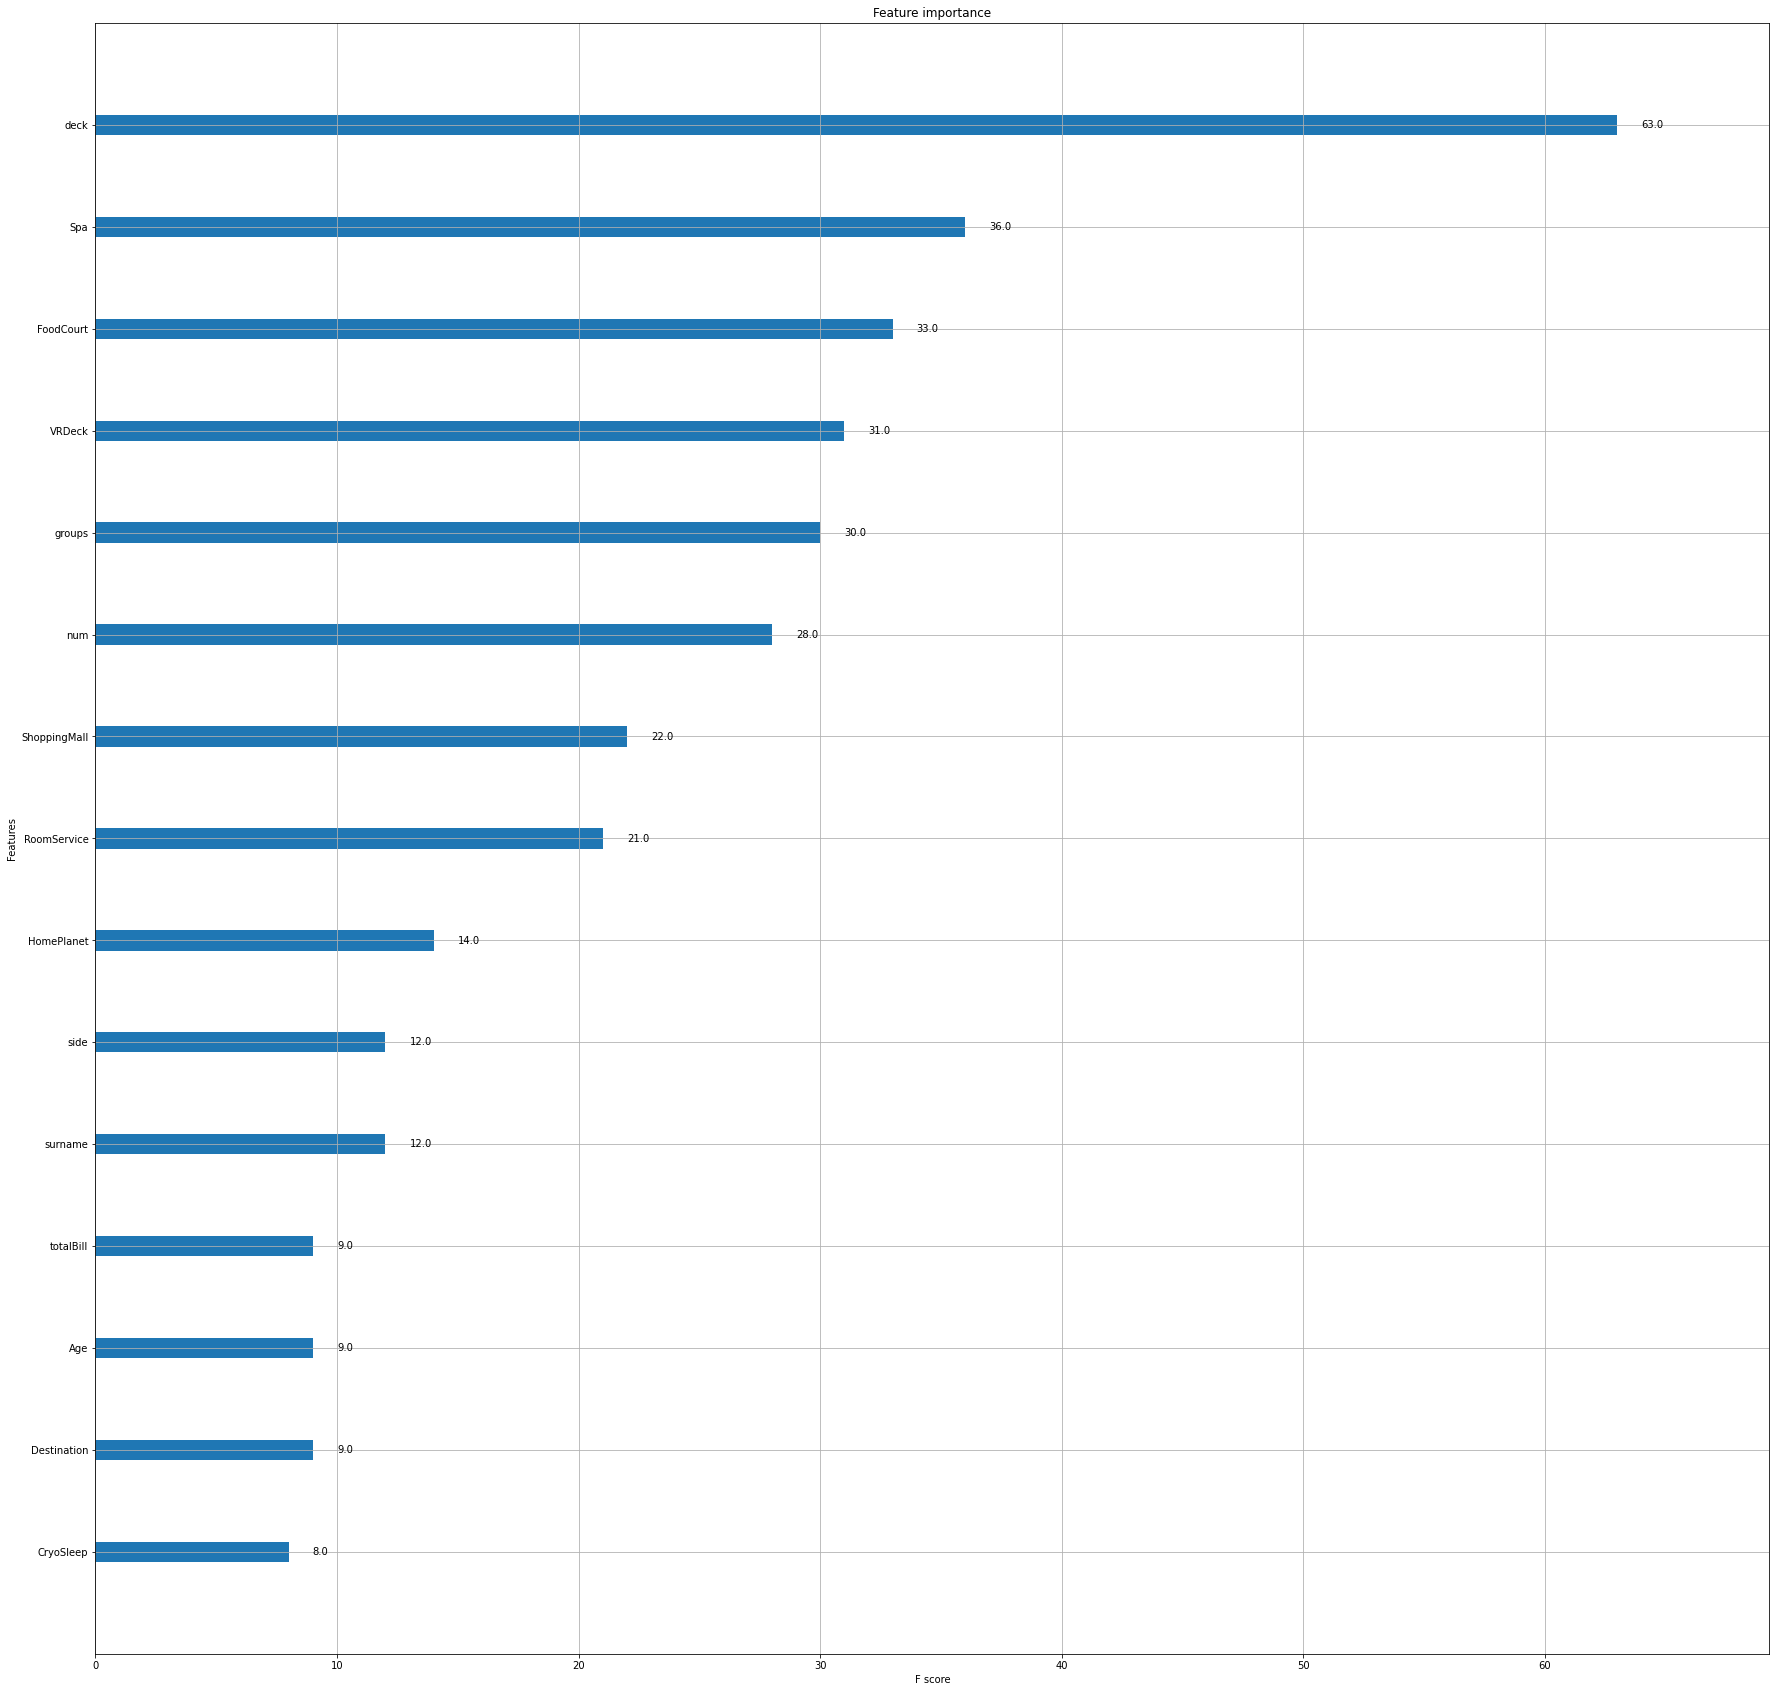

In [270]:
xgb.plot_importance(bst)

<AxesSubplot:>

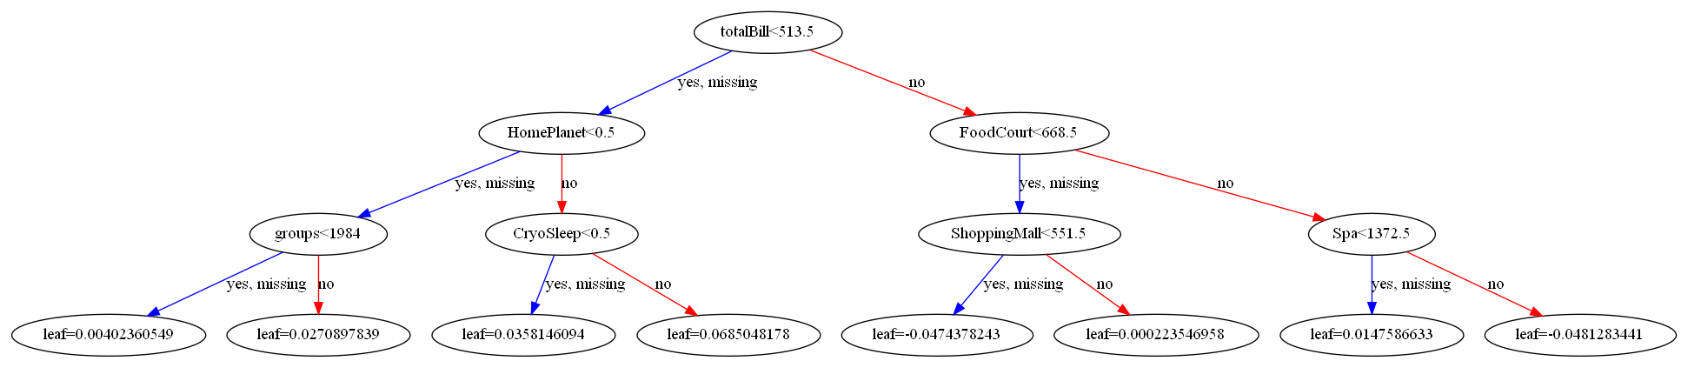

In [271]:
xgb.plot_tree(bst)

In [272]:
resultDf = pd.DataFrame()
resultDf['PassengerId'] = testDf['PassengerId']
resultDf['Transported'] = prediction
resultDf.to_csv('submission.csv',index=False)